In [79]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat, u_darrays
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot, u_darrays as uda, u_met
import pandas as pd
import metpy
from metpy import calc
from metpy.units import units
import salem

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [4]:
import sys
print(sys.executable)

/home/ck/miniconda3/envs/test/bin/python


In [3]:
era_pl = xr.open_dataset(cnst.ERA5_MONTHLY_PL_SYNOP)
era_pl = era_pl.where((era_pl['q'])['time.hour'] == 12, drop=True)
era_pl = u_darrays.flip_lat(era_pl)

In [4]:
era_srfc = xr.open_dataset(cnst.ERA5_MONTHLY_SRFC_SYNOP)
era_srfc = era_srfc.where((era_srfc['t2m'])['time.hour'] == 12, drop=True)
era_srfc = u_darrays.flip_lat(era_srfc)

In [5]:
era_srfc = era_srfc.sel(latitude=slice(4.5,17.5), longitude=slice(-10,10)).groupby('time.month').mean('longitude')

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [6]:
era_pl = era_pl.sel(latitude=slice(4.5,17.5), longitude=slice(-10,10)).groupby('time.month').mean('longitude')

In [209]:
slopes = pkl.load(open(cnst.CLOVER_SAVES + 'q_shear_sensitivity_slopes', 'rb'))
qslope = 1.39 #slopes['qslope'] 1.89
shear_slope = 0.52 #slopes['shear_slope'] 1.03
qshear_slope = 0.035

In [110]:
slopes  # qslope: Pmax per g kg-1 , shear_slope, Pmax per m s-1

{'shear_slope': 0.34796322061081403, 'qslope': 2.2265218813935386}

In [111]:
slopes

{'shear_slope': 0.34796322061081403, 'qslope': 2.2265218813935386}

In [112]:
era_srfc

<xarray.Dataset>
Dimensions:   (latitude: 19, time: 483)
Coordinates:
  * latitude  (latitude) float32 4.9 5.6 6.3 7.0 7.7 ... 15.4 16.1 16.8 17.5
  * time      (time) datetime64[ns] 1979-01-01T12:00:00 ... 2019-03-01T12:00:00
Data variables:
    u100      (time, latitude) float32 2.0904224 1.463452 ... -4.4335527
    v100      (time, latitude) float32 1.4105633 0.7493878 ... -2.589931
    u10       (time, latitude) float32 1.859331 1.2274178 ... -3.7785645
    v10       (time, latitude) float32 1.2729981 0.65397406 ... -2.2530904
    d2m       (time, latitude) float32 296.80423 296.27313 ... 269.41962
    t2m       (time, latitude) float32 301.3226 302.55624 ... 305.20526
    blh       (time, latitude) float32 673.1166 923.07404 ... 1197.924 1146.2201
    cape      (time, latitude) float32 1422.4355 1391.3457 ... 1.1393607
    cin       (time, latitude) float32 94.96181 111.46771 159.81181 ... nan nan
    hcc       (time, latitude) float32 0.2662042 0.24549177 ... 0.25830752
    msl       (time, latitude) float32 101015.516 101002.06 ... 101282.12
    slhf      (time, latitude) float32 -558318.4 -715223.5 ... -13780.186
    sp        (time, latitude) float32 100548.79 100034.35 ... 97433.6 97182.82
    sshf      (time, latitude) float32 -230889.52 -483508.34 ... -777086.3
    tcwv      (time, latitude) float32 46.35244 44.149055 ... 14.488662
    p84.162   (time, latitude) float32 -2.6959153e-05 ... -5.8749947e-06
    vimd      (time, latitude) float32 -0.18846531 -0.06940625 ... -0.01693671
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 5 6 7 8 9 10 11 12 1 2 3

In [11]:
u_shear = (era_pl['u'].sel(level=650) - era_pl['u'].sel(level=925))*-1
sheardiff = u_shear.groupby('time.month').std('time') #/ u_shear.groupby('time.month').mean('time')
shearmean = u_shear.groupby('time.month').mean('time')

q = era_pl['q'].sel(level=925)*1000
qdiff = q.groupby('time.month').std('time') #/ q.groupby('time.month').mean('time') #.apply(lambda x: x - x.mean())
qmean = q.groupby('time.month').mean('time')

theta_low = u_met.theta_e(925,era_pl['t'].sel(level=925).values-273.15,era_pl['q'].sel(level=925).values)
theta_high = u_met.theta_e(700,era_pl['t'].sel(level=700).values-273.15,era_pl['q'].sel(level=700).values)
thetadiff = era_srfc['t2m'].copy()
thetadiff.values = theta_low-theta_high
thetadiff = thetadiff.groupby('time.month').std('time')

qshearmean = qmean*shearmean
qshearstd = qdiff*sheardiff

In [12]:
qshearstd

<xarray.DataArray (month: 12, latitude: 19)>
array([[2.5953068 , 2.90207076, 3.3469917 , 3.70098268, 3.74708598,
        3.36497288, 2.64549084, 1.98233917, 1.43861278, 1.0627033 ,
        0.85208631, 0.7396918 , 0.67730554, 0.67674291, 0.67899227,
        0.70310039, 0.74085872, 0.78715849, 0.85173608],
       [1.62134155, 2.0029308 , 2.72384117, 3.64324979, 4.34284423,
        4.6391966 , 4.18456281, 3.46371523, 2.66105992, 1.88109753,
        1.36142809, 1.1015168 , 1.01767214, 1.01558727, 1.04170715,
        1.10114763, 1.17503808, 1.23465461, 1.29756312],
       [0.5187446 , 0.58952362, 0.86576901, 1.36693233, 1.91543507,
        2.56384103, 3.16133242, 3.66008196, 3.84564158, 3.48900017,
        2.7683483 , 2.0733544 , 1.58276848, 1.29098333, 1.13466539,
        1.04905405, 1.02882063, 1.0235677 , 1.05414715],
       [0.51641667, 0.48187848, 0.46620023, 0.48757492, 0.54720218,
        0.7055128 , 1.04587782, 1.50796451, 2.10555674, 2.71431875,
        3.13024318, 3.20230458, 3.07250998, 2.74320252, 2.16558625,
        1.70480328, 1.40968241, 1.23673263, 1.15391847],
       [0.41587723, 0.40238379, 0.38653822, 0.38182358, 0.3785139 ,
        0.38242412, 0.39177737, 0.47289829, 0.58147607, 0.80846835,
        1.07343954, 1.30425657, 1.53115976, 1.71496123, 1.83399631,
        1.87880651, 1.85135847, 1.74593048, 1.65414248],
       [0.35992326, 0.33075908, 0.31881512, 0.30632185, 0.30409717,
        0.29175943, 0.28555906, 0.28260343, 0.30221858, 0.36768373,
        0.4667491 , 0.59606776, 0.72644143, 0.82086477, 0.94486341,
        1.06339772, 1.14970574, 1.21793242, 1.23028509],
       [0.49143279, 0.47630765, 0.44406257, 0.41564644, 0.37224695,
        0.32797067, 0.27829106, 0.2387615 , 0.20698758, 0.19821665,
        0.20492199, 0.2211726 , 0.23291653, 0.26243638, 0.33929949,
        0.46859284, 0.64964623, 0.84545577, 0.94408738],
       [0.42862323, 0.42669049, 0.44866289, 0.46607958, 0.48734599,
        0.47212921, 0.43412045, 0.38812477, 0.36214371, 0.33484239,
        0.3009972 , 0.27938588, 0.26737066, 0.29776073, 0.39099047,
        0.56079153, 0.81293649, 1.06624975, 1.23854124],
       [0.42376767, 0.38951941, 0.38114968, 0.37635429, 0.37673707,
        0.33439608, 0.30744481, 0.2854134 , 0.26676531, 0.26322611,
        0.28275575, 0.34447982, 0.50420368, 0.77223333, 1.10192802,
        1.3891849 , 1.67426882, 1.83473887, 1.76673344],
       [0.40047767, 0.37163679, 0.35585883, 0.33804895, 0.3336094 ,
        0.3776445 , 0.55263378, 0.8098471 , 1.23002743, 1.86086491,
        2.40140053, 2.75761137, 2.97916902, 2.91435403, 2.43160077,
        1.90972922, 1.56291904, 1.32934149, 1.2020765 ],
       [0.37860665, 0.42614084, 0.55876577, 0.83905906, 1.11816561,
        1.39781974, 1.50575702, 1.55187271, 1.55873547, 1.4281741 ,
        1.23886264, 1.01579048, 0.87168188, 0.77809482, 0.70321739,
        0.64087966, 0.61443818, 0.62013303, 0.64311839],
       [0.74365995, 0.896889  , 1.14790316, 1.50025853, 1.7842435 ,
        1.91288581, 1.57002955, 1.27516173, 0.96528906, 0.67751436,
        0.51847838, 0.48573247, 0.49752772, 0.5171533 , 0.55305514,
        0.60404091, 0.66374872, 0.72220154, 0.77880885]])
Coordinates:
    level     float64 925.0
  * latitude  (latitude) float32 4.9 5.6 6.3 7.0 7.7 ... 15.4 16.1 16.8 17.5
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [13]:
## a clean way of plotting - use matplotlib functions directly:

def draw_map(ax, data, lon, lat, l1, l2, nb,title=None,  text=None, mask_sig=None, quiver=None, contour=None, contour2=None, cbar_label=None,cmap=None):
    #mapp = ax.contourf(lon, lat, data, **kwargs)  # this is the actual plot
    nb_lev = nb
    cmapp = uplot.discrete_cmap(nb_lev, base_cmap=cmap)

#     mapp = ax.pcolormesh(np.arange(0.5,13,1), lat,data
#                           ,cmap=cmapp, vmin=l1, vmax=l2)
    #ipdb.set_trace()
    mapp = ax.contourf(np.arange(1,13).astype(str), lat,data, levels=np.round(np.linspace(l1,l2,nb),2), cmap=cmap, extend='both' )
    plt.xlabel('Month')
    plt.ylabel('Latitude')
    #cbar = plt.colorbar(mapp, ticks=np.linspace(l1,l2,nb_lev+1))
    cbar = plt.colorbar(mapp)
    plt.title(title)
    #plt.text(0.03,0.95, text, transform=ax.transAxes, fontsize=14)
    ax.axhline(8.5, linestyle='dashed')
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.pcolormesh(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        plt.clabel(cs, inline=1, fontsize=8, fmt="%1.1f")
        
    if contour2 is not None:
        cs = ax.contour(contour2['x'], contour2['y'], contour2['data'], levels=contour2['levels'], colors=contour2['color'], linewidths=0.5 )
        plt.clabel(cs, inline=1, fontsize=8, fmt="%1.1f")
    
#     ax.coastlines()   ## adds coastlines
#     # Gridlines
#     xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
#     xl.xlabels_top = False   ## labels off
#     xl.ylabels_right = False
#     plt.title(title)
#     # Countries
#     ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
   # cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)   

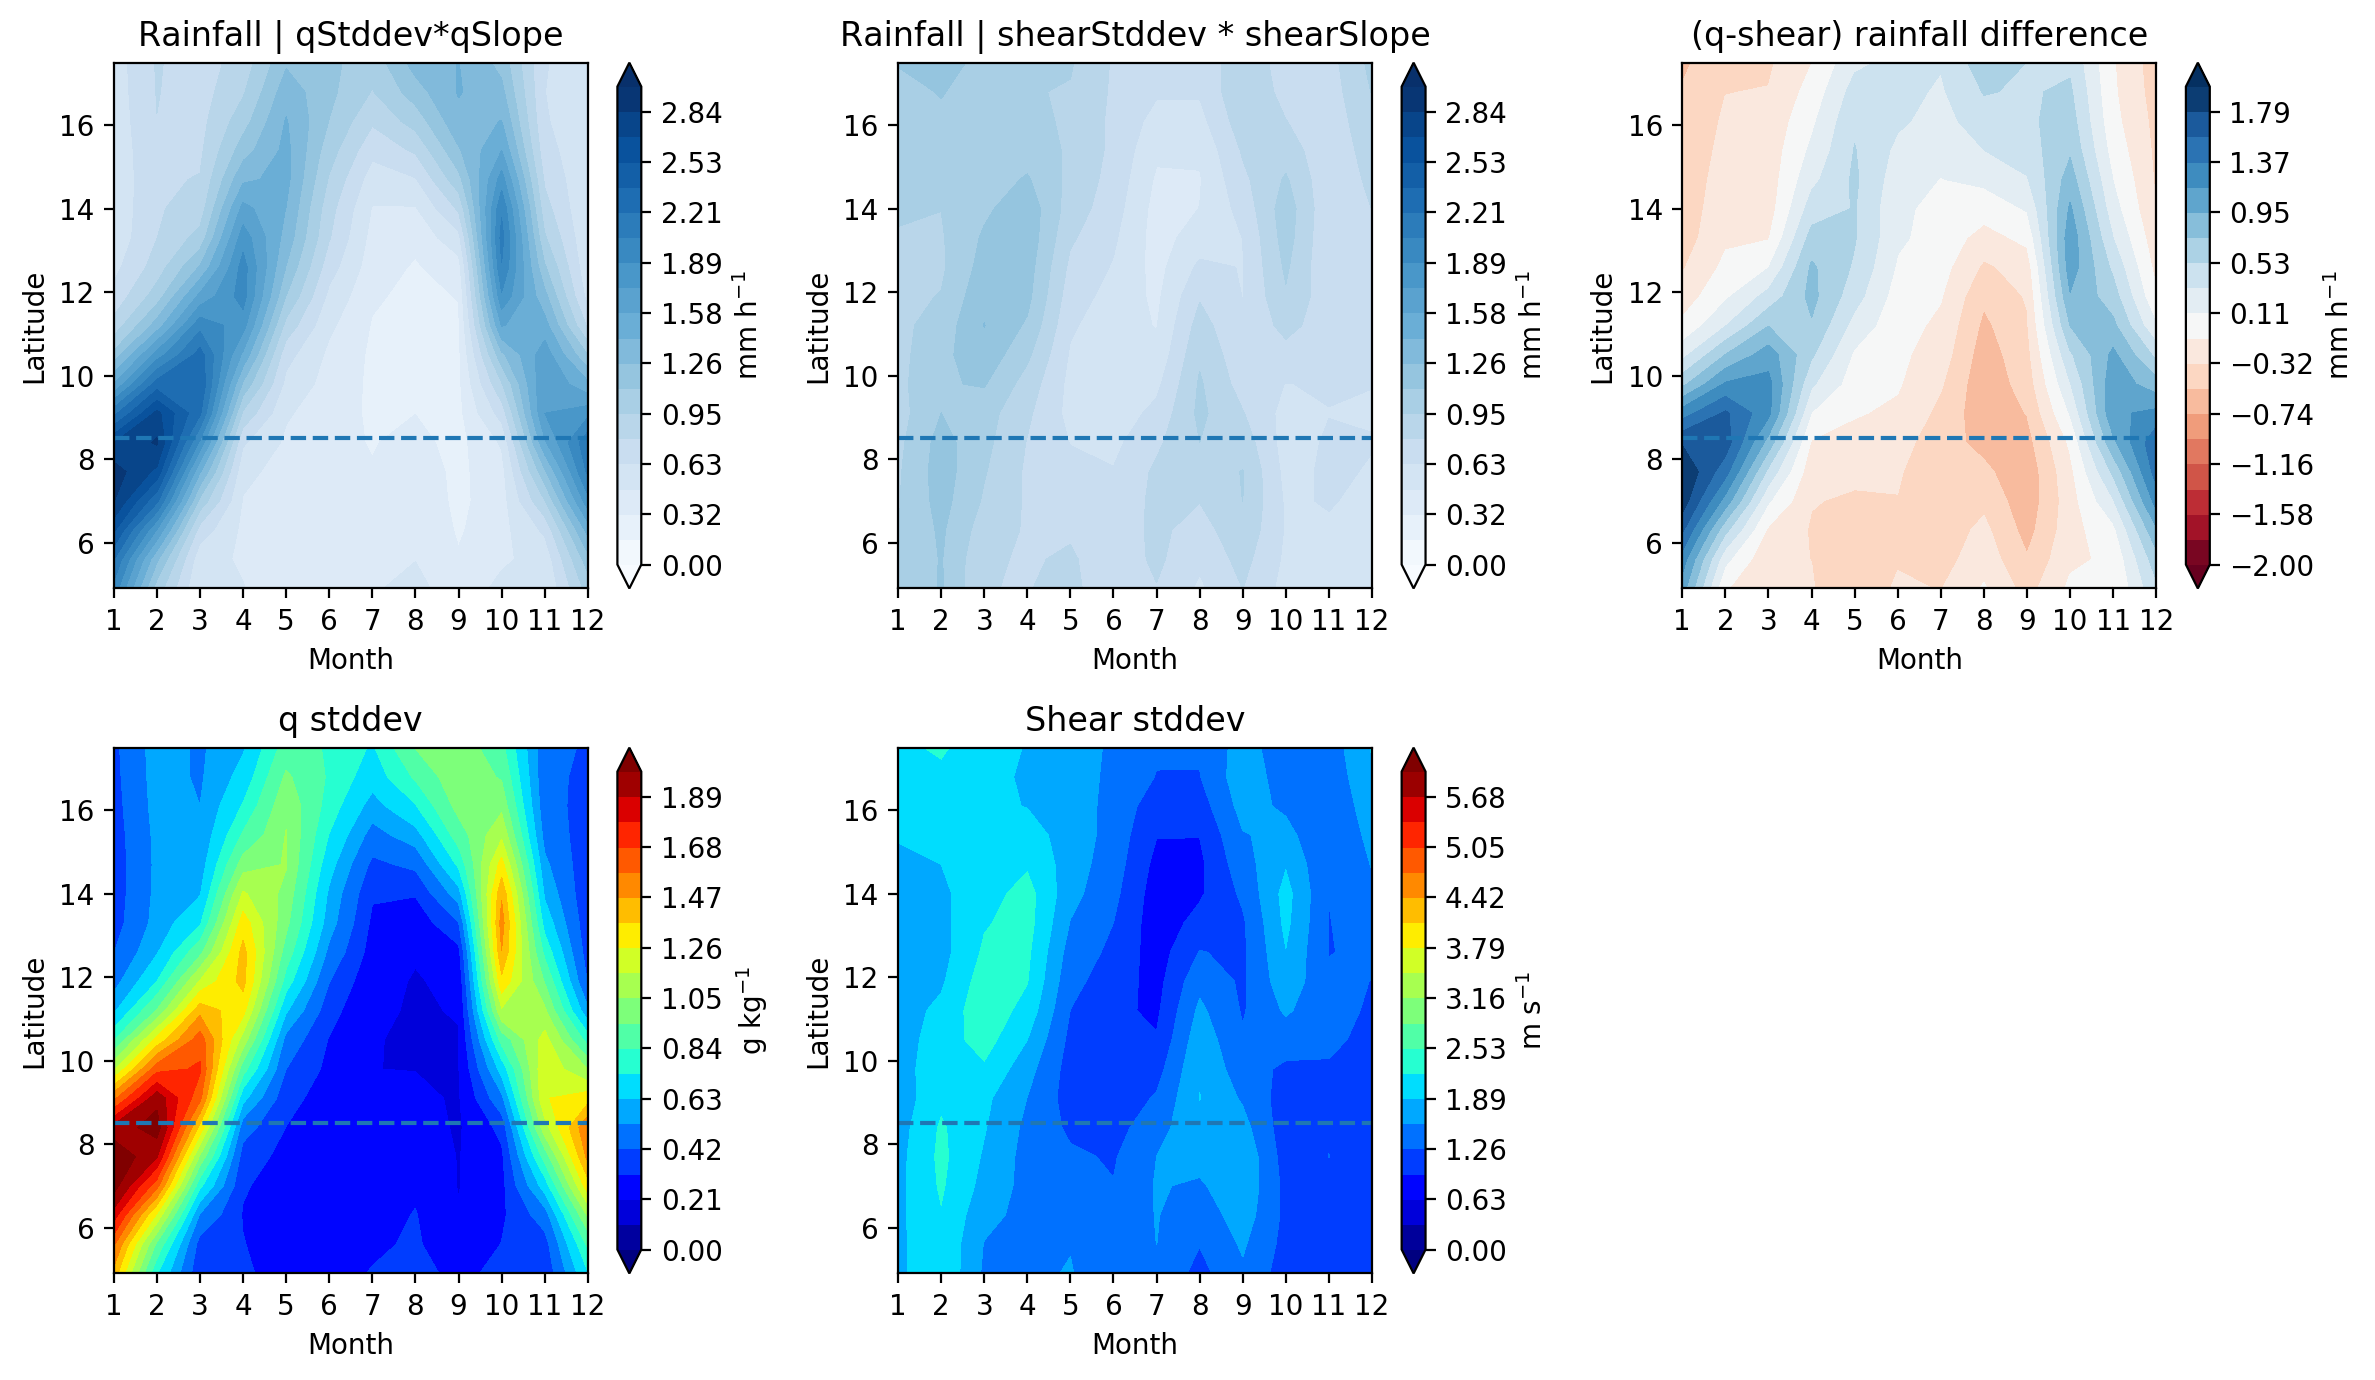

In [14]:
f = plt.figure(figsize=(12,7), dpi=200)
ax = f.add_subplot(231)
#contour2 = {'x' : tdiff.month.values, 'y': cape.latitude.values, 'data': q.T, 'levels': [10,12,14,14.5,15,15.2,15.5,15.7,16], 'color':'red'}
draw_map(ax, qdiff.T.values*qslope, np.arange(1,13).astype(str), qdiff.latitude.values , 0, 3, 20, cmap='Blues',  \
         title=r"Rainfall | qStddev*qSlope", text='(e)', cbar_label='mm h$^{-1}$')


ax = f.add_subplot(232)
draw_map(ax,sheardiff.T.values*shear_slope, np.arange(1,13).astype(str), qdiff.latitude.values , 0, 3,20, \
         title=r"Rainfall | shearStddev * shearSlope",  text='(c)',cmap='Blues', cbar_label='mm h$^{-1}$')

ax = f.add_subplot(233)
draw_map(ax,(qdiff.T.values*qslope)-(sheardiff.T.values*shear_slope), np.arange(1,13).astype(str), qdiff.latitude.values , -2, 2,20, \
         title=r"(q-shear) rainfall difference",  text='(c)',cmap='RdBu', cbar_label='mm h$^{-1}$')

ax = f.add_subplot(234)
draw_map(ax,qdiff.T.values, np.arange(1,13).astype(str), qdiff.latitude.values , 0, 2,20, \
         title=r"q stddev",  text='(c)',cmap='jet', cbar_label='g kg$^{-1}$')

ax = f.add_subplot(235)
draw_map(ax,sheardiff.T.values, np.arange(1,13).astype(str), qdiff.latitude.values , 0, 6,20, \
         title=r"Shear stddev",  text='(c)',cmap='jet', cbar_label='m s$^{-1}$')

plt.tight_layout()
plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/stddev_climatological.jpg')

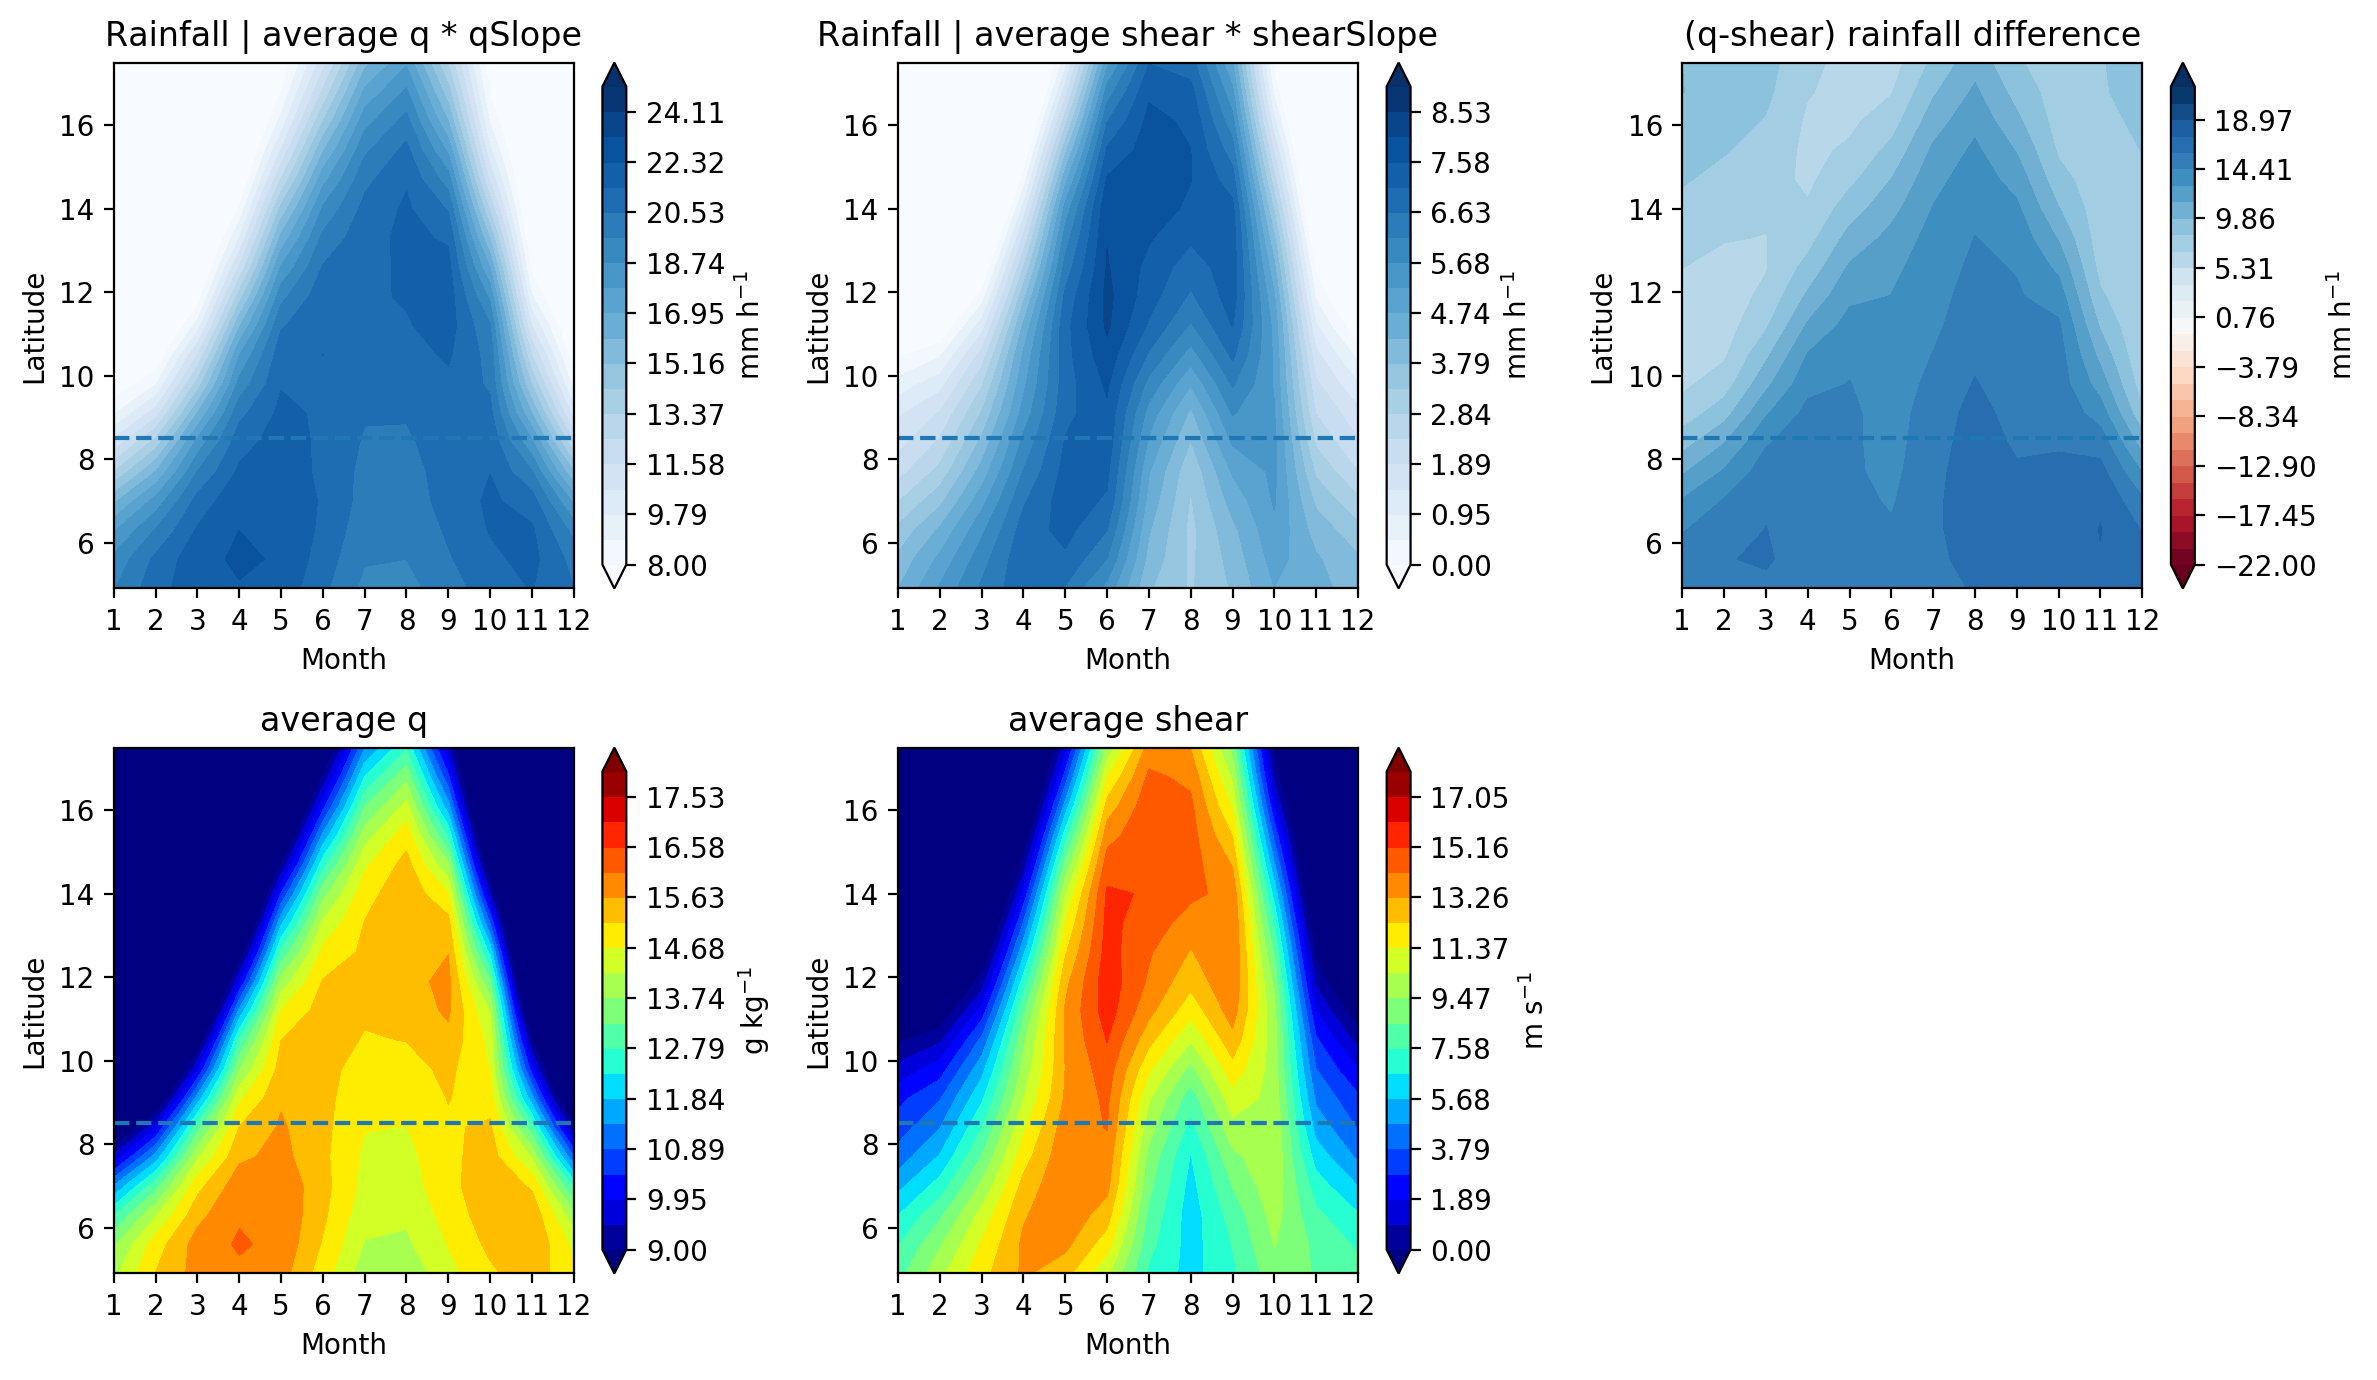

In [191]:
f = plt.figure(figsize=(12,7), dpi=200)
ax = f.add_subplot(231)
#contour2 = {'x' : tdiff.month.values, 'y': cape.latitude.values, 'data': q.T, 'levels': [10,12,14,14.5,15,15.2,15.5,15.7,16], 'color':'red'}
draw_map(ax, qmean.T.values*qslope, range(1,13), qdiff.latitude.values , 8, 25, 20, cmap='Blues',  \
         title=r"Rainfall | average q * qSlope", text='(e)', cbar_label='mm h$^{-1}$')


ax = f.add_subplot(232)
draw_map(ax,shearmean.T.values*shear_slope, np.arange(1,13).astype(str), qdiff.latitude.values , 0, 9,20, \
         title=r"Rainfall | average shear * shearSlope",  text='(c)',cmap='Blues', cbar_label='mm h$^{-1}$')

ax = f.add_subplot(233)
draw_map(ax,(qmean.T.values*qslope)-(shearmean.T.values*shear_slope), np.arange(1,13).astype(int), qdiff.latitude.values , -22, 22,30, \
         title=r"(q-shear) rainfall difference",  text='(c)',cmap='RdBu', cbar_label='mm h$^{-1}$')

ax = f.add_subplot(234)
draw_map(ax,qmean.T.values, np.arange(1,13).astype(int), qdiff.latitude.values , 9, 18,20, \
         title=r"average q",  text='(c)',cmap='jet', cbar_label='g kg$^{-1}$')

ax = f.add_subplot(235)
draw_map(ax,shearmean.T.values, np.arange(1,13).astype(int), qdiff.latitude.values , 0, 18,20, \
         title=r"average shear",  text='(c)',cmap='jet', cbar_label='m s$^{-1}$')


plt.tight_layout()
plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/mean_climatological.jpg')

In [16]:
stormin = era_srfc['t2m'].groupby('time.month').mean('time').copy()
stormin = stormin.sel(latitude=slice(4.5,17.5), month=slice(3,11))

In [17]:
ds = xr.Dataset()

In [18]:
ar = np.zeros((7025,12,19))*np.nan

In [19]:
da = xr.DataArray(ar, coords={'time': np.arange(7025), 'month': range(1,13), 'lat': stormin.latitude.values},
                            dims=['time', 'month', 'lat'])  

In [31]:
ds['q'] = da.copy()
ds['shear'] = da.copy()
ds['valid'] = da.copy()
ds['prcp'] = da.copy()

In [32]:
ds

<xarray.Dataset>
Dimensions:  (lat: 19, month: 12, time: 7025)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 ... 7018 7019 7020 7021 7022 7023 7024
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 4.9 5.6 6.3 7.0 7.7 8.4 ... 14.7 15.4 16.1 16.8 17.5
Data variables:
    q        (time, month, lat) float64 nan nan nan nan nan ... nan nan nan nan
    shear    (time, month, lat) float64 nan nan nan nan nan ... nan nan nan nan
    valid    (time, month, lat) float64 nan nan nan nan nan ... nan nan nan nan
    prcp     (time, month, lat) float64 nan nan nan nan nan ... nan nan nan nan

In [22]:
OBS2 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_ERA5_5-20N_p15.p', 'rb'))

In [33]:
def create_dic(dic):
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shear']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['u650'])
    umax = np.array(dic['u925'])
    qq = np.array(dic['q925']) 
    qup = np.array(dic['q650'])
    tup = np.array(dic['t650'])
    tlow = np.array(dic['t925'])
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])
    
    
    pdub = np.array([650]*len(tlow))
    p = units.Quantity(650, 'hPa')
    t = units.Quantity(tup, 'K')
    
    thetae_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
    #thetae_up = u_met.theta_e(650, tup-273.15, qup)
    
    thetae_down = u_met.theta_e(925, tlow-273.15, qq)
    
    thetae = thetae_down - thetae_up
    
    theta_up = u_met.theta(650, tup-273.15)
    theta_down = u_met.theta(925, tlow-273.15)
    
    theta = theta_down - theta_up

    obs_pcp = {
        'prcp' : pp,
        'u650' : umin,
        'u925' : umax,
        'q925' : qq*1000,
        'q650' : qup*1000,
        't925' : tlow-273.15,
        't650' : tup-273.15,
        'shear' : sh*-1,
        'month' : month,
        'area' : (area)*(5**2),
        'tmin' : tt,
        'tmean' : ttm,
        'theta' : theta,
        'theta_e' : thetae,
        'thup' : thetae_up,
        'thdown' : thetae_down,
        'lat' : lat,
        'lon' : lon,
    } 
    obs = pd.DataFrame(obs_pcp)
    return obs

In [34]:
obs_gpm = create_dic(OBS2)

In [35]:
obs_gpm = obs_gpm[(obs_gpm.lon>=-10)&(obs_gpm.lon<=12)]#&(obs_gpm.lat>=5.2)&(obs_gpm.lat<=8.3)]

In [36]:
oposi = (obs_gpm.q925>=9.5) & (obs_gpm.shear>-5) &  (obs_gpm.prcp>=5)

In [37]:
obsp = obs_gpm[oposi]
len(obsp)

39002

In [38]:
len(obsp[obsp.month==10])

3465

In [77]:
obsp.keys()

Index(['prcp', 'u650', 'u925', 'q925', 'q650', 't925', 't650', 'shear',
       'month', 'area', 'tmin', 'tmean', 'theta', 'theta_e', 'thup', 'thdown',
       'lat', 'lon'],
      dtype='object')

In [78]:
extr_rain = xr.open_dataarray('/home/ck/DIR/cornkle/figs/CLOVER/maxRain_hov_GPM_17-19UTC.nc')

In [40]:
for m in range(3,12):
    pick = obsp[obsp.month==m]
    for ids, obs in enumerate(pick.iterrows()):
            #ipdb.set_trace()
            point = ds.sel(time=ids, lat=obs[1].lat, month=obs[1].month, method='nearest')
            plat = point['lat'].values
            month = point['month'].values

            xpos = np.where(ds['month'].values == month)
            xpos = int(xpos[0])
            ypos = np.where(ds['lat'].values == plat)
            ypos = int(ypos[0])
            #print(ids,xpos,ypos)
            ds['q'].values[ids,xpos,ypos] = obs[1]['q925']
            ds['shear'].values[ids,xpos,ypos] = obs[1]['shear']
            ds['valid'].values[ids,xpos,ypos] = 1
            ds['prcp'].values[ids,xpos,ypos] = obs[1]['prcp']

In [64]:
ds['prcp'].values.shape

(7025, 12, 19)

In [165]:
test = ds.std('time')
mean = ds.mean('time')
pmax = ds['prcp'].mean('time')#quantile(0.8, dim='time')
qshearevent = mean['q'].values*mean['shear'].values
qsheardeventSTD = test['q'].values*test['shear'].values

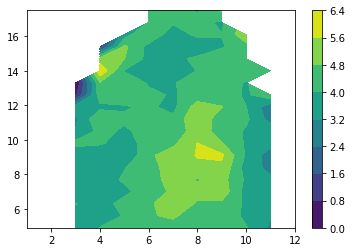

In [166]:
plt.contourf(ds.month, ds.lat,test['shear'].T)
plt.colorbar()

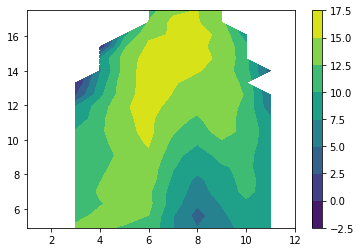

In [167]:
plt.contourf(ds.month, ds.lat,mean['shear'].T)
plt.colorbar()

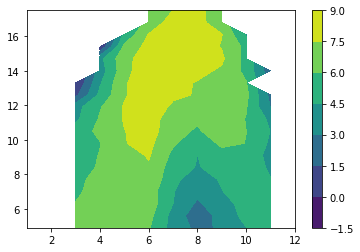

In [168]:
plt.contourf(ds.month, ds.lat,mean['shear'].T.values*shear_slope)
plt.colorbar()

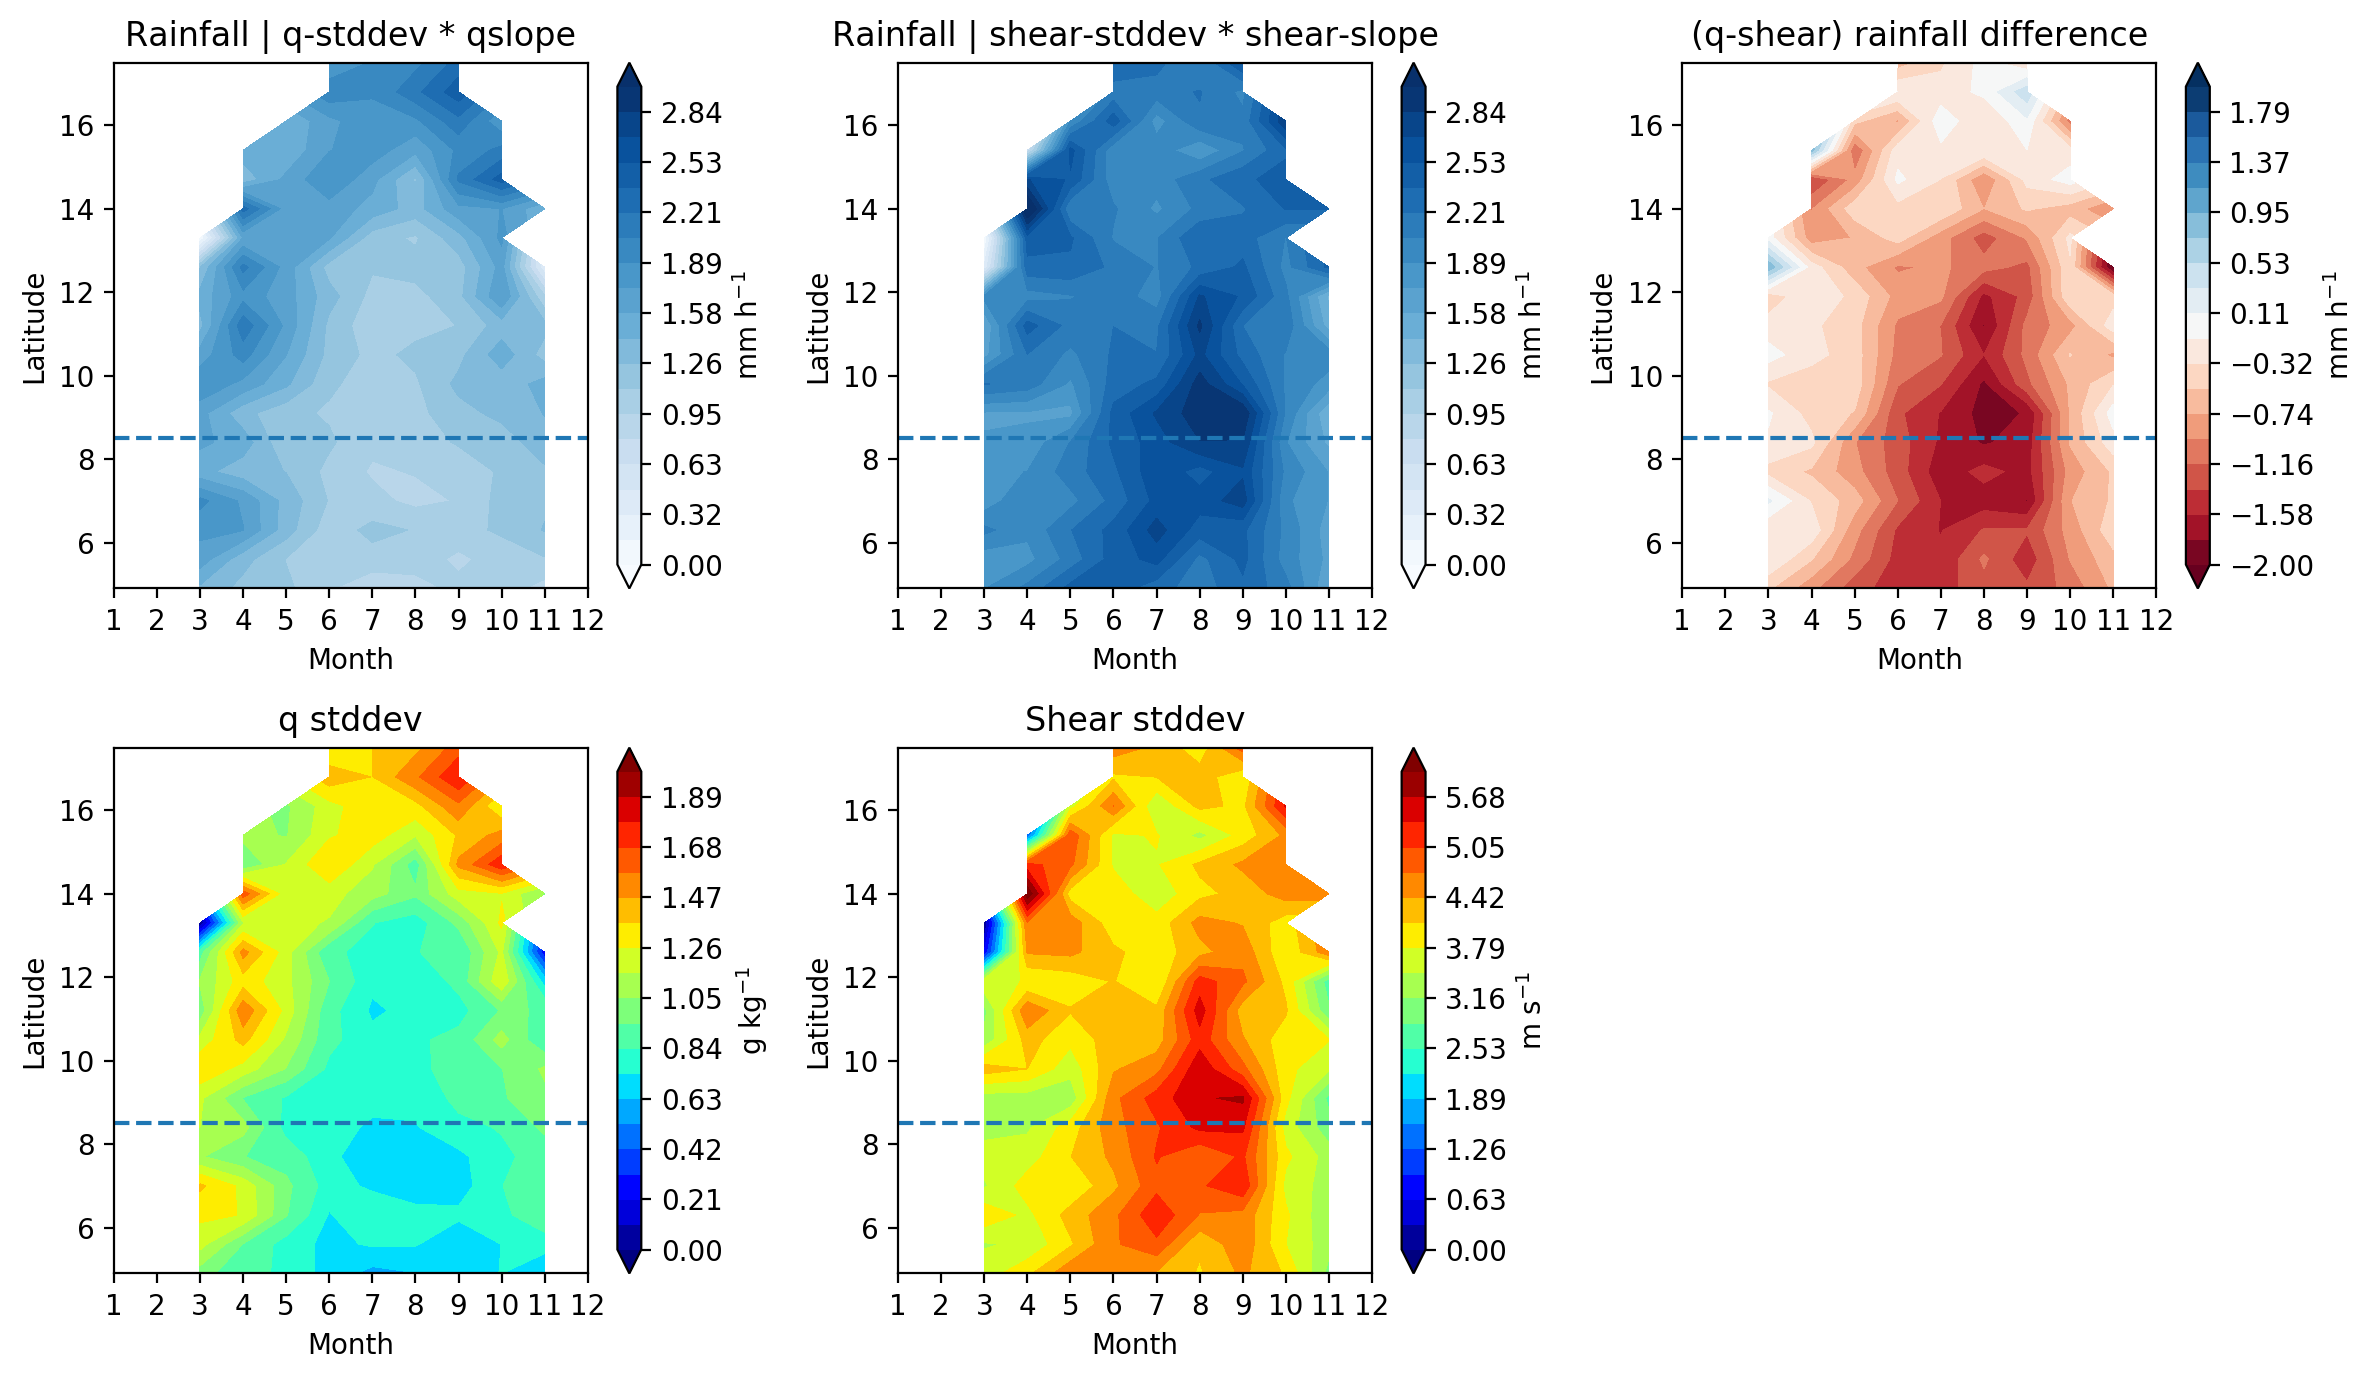

In [169]:
f = plt.figure(figsize=(12,7), dpi=200)
ax = f.add_subplot(231)
#contour2 = {'x' : tdiff.month.values, 'y': cape.latitude.values, 'data': q.T, 'levels': [10,12,14,14.5,15,15.2,15.5,15.7,16], 'color':'red'}
draw_map(ax, test['q'].T.values*qslope, range(1,13), ds.lat.values , 0, 3, 20, cmap='Blues',  \
         title=r"Rainfall | q-stddev * qslope", text='(e)', cbar_label='mm h$^{-1}$')


ax = f.add_subplot(232)
draw_map(ax,test['shear'].T.values*shear_slope, np.arange(1,13).astype(str), ds.lat.values , 0, 3,20, \
         title=r"Rainfall | shear-stddev * shear-slope",  text='(c)',cmap='Blues', cbar_label='mm h$^{-1}$')

ax = f.add_subplot(233)
draw_map(ax,(test['q'].T.values*qslope)-(test['shear'].T.values*shear_slope), np.arange(1,13).astype(int), ds.lat.values , -2, 2,20, \
         title=r"(q-shear) rainfall difference",  text='(c)',cmap='RdBu', cbar_label='mm h$^{-1}$')

ax = f.add_subplot(234)
draw_map(ax,test['q'].T.values, np.arange(1,13).astype(int), ds.lat.values , 0, 2,20, \
         title=r"q stddev",  text='(c)',cmap='jet', cbar_label='g kg$^{-1}$')

ax = f.add_subplot(235)
draw_map(ax,test['shear'].T.values, np.arange(1,13).astype(int), ds.lat.values , 0, 6,20, \
         title=r"Shear stddev",  text='(c)',cmap='jet', cbar_label='m s$^{-1}$')


plt.tight_layout()
plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/stddev_stormTime.jpg')

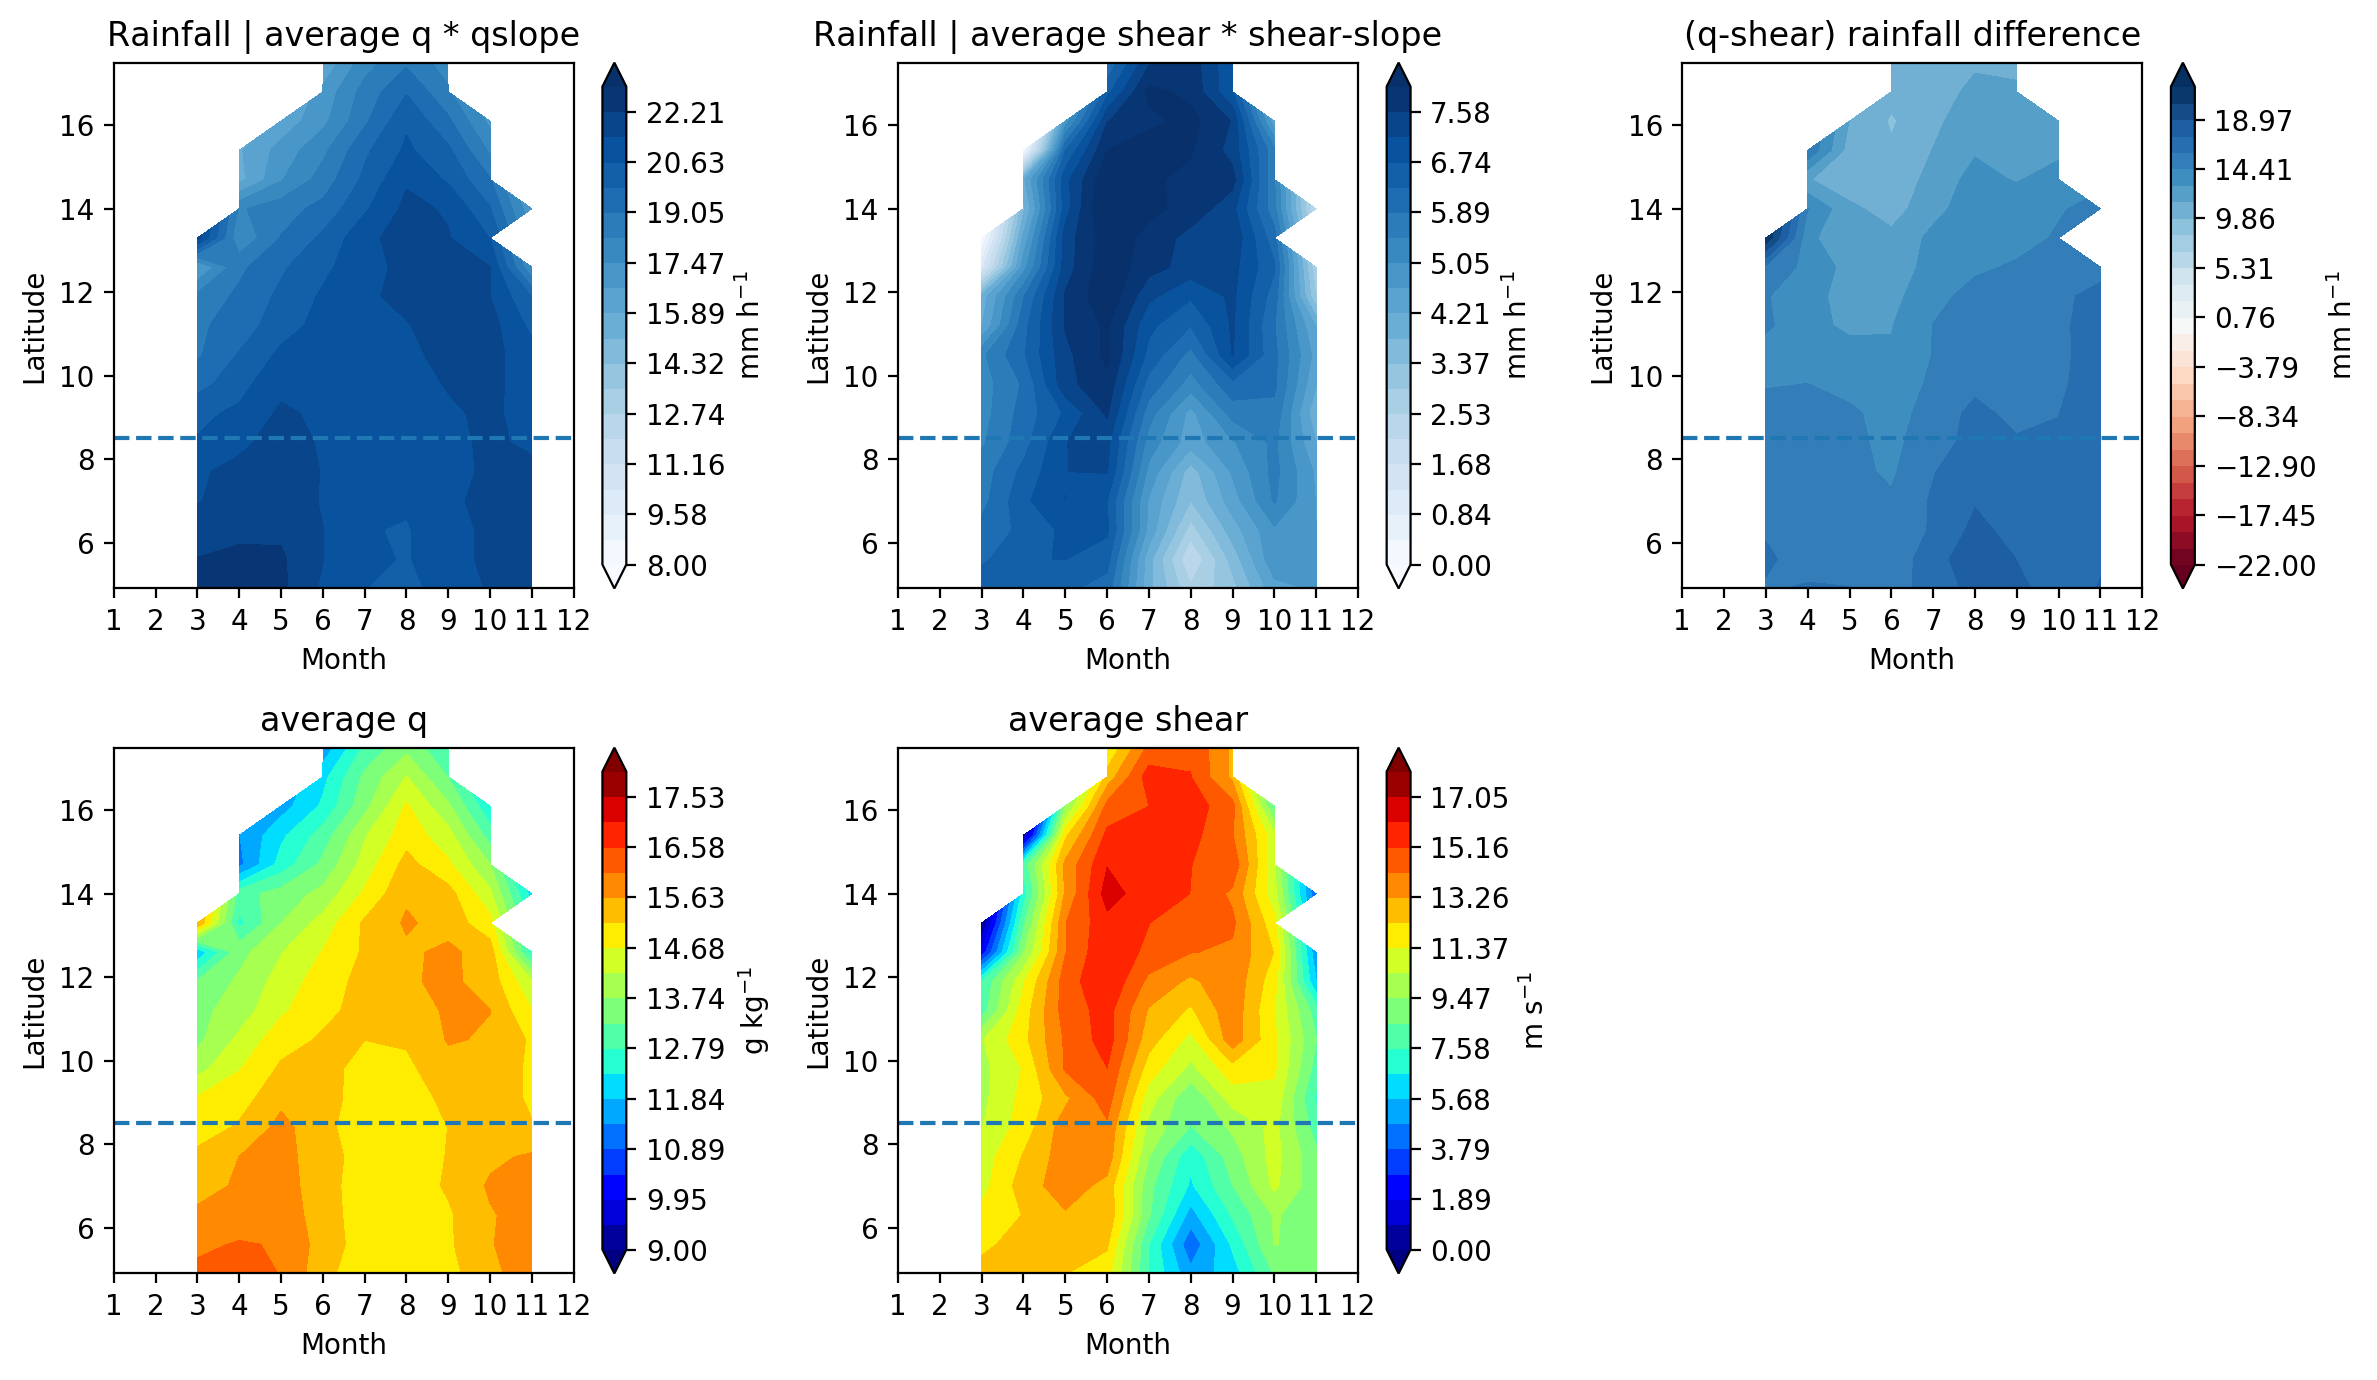

In [189]:
f = plt.figure(figsize=(12,7), dpi=200)
ax = f.add_subplot(231)
#contour2 = {'x' : tdiff.month.values, 'y': cape.latitude.values, 'data': q.T, 'levels': [10,12,14,14.5,15,15.2,15.5,15.7,16], 'color':'red'}
draw_map(ax, mean['q'].T.values*qslope, range(1,13), ds.lat.values , 8, 23, 20, cmap='Blues',  \
         title=r"Rainfall | average q * qslope", text='(e)', cbar_label='mm h$^{-1}$')


ax = f.add_subplot(232)
draw_map(ax,mean['shear'].T.values*shear_slope, np.arange(1,13).astype(str), ds.lat.values , 0, 8,20, \
         title=r"Rainfall | average shear * shear-slope",  text='(c)',cmap='Blues', cbar_label='mm h$^{-1}$')

ax = f.add_subplot(233)
draw_map(ax,(mean['q'].T.values*qslope)-(mean['shear'].T.values*shear_slope), np.arange(1,13).astype(int), ds.lat.values , -22, 22,30, \
         title=r"(q-shear) rainfall difference",  text='(c)',cmap='RdBu', cbar_label='mm h$^{-1}$')

ax = f.add_subplot(234)
draw_map(ax,mean['q'].T.values, np.arange(1,13).astype(int), ds.lat.values , 9, 18,20, \
         title=r"average q",  text='(c)',cmap='jet', cbar_label='g kg$^{-1}$')

ax = f.add_subplot(235)
draw_map(ax,mean['shear'].T.values, np.arange(1,13).astype(int), ds.lat.values , 0, 18,20, \
         title=r"average shear",  text='(c)',cmap='jet', cbar_label='m s$^{-1}$')


plt.tight_layout()
plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/mean_stormTime.jpg')

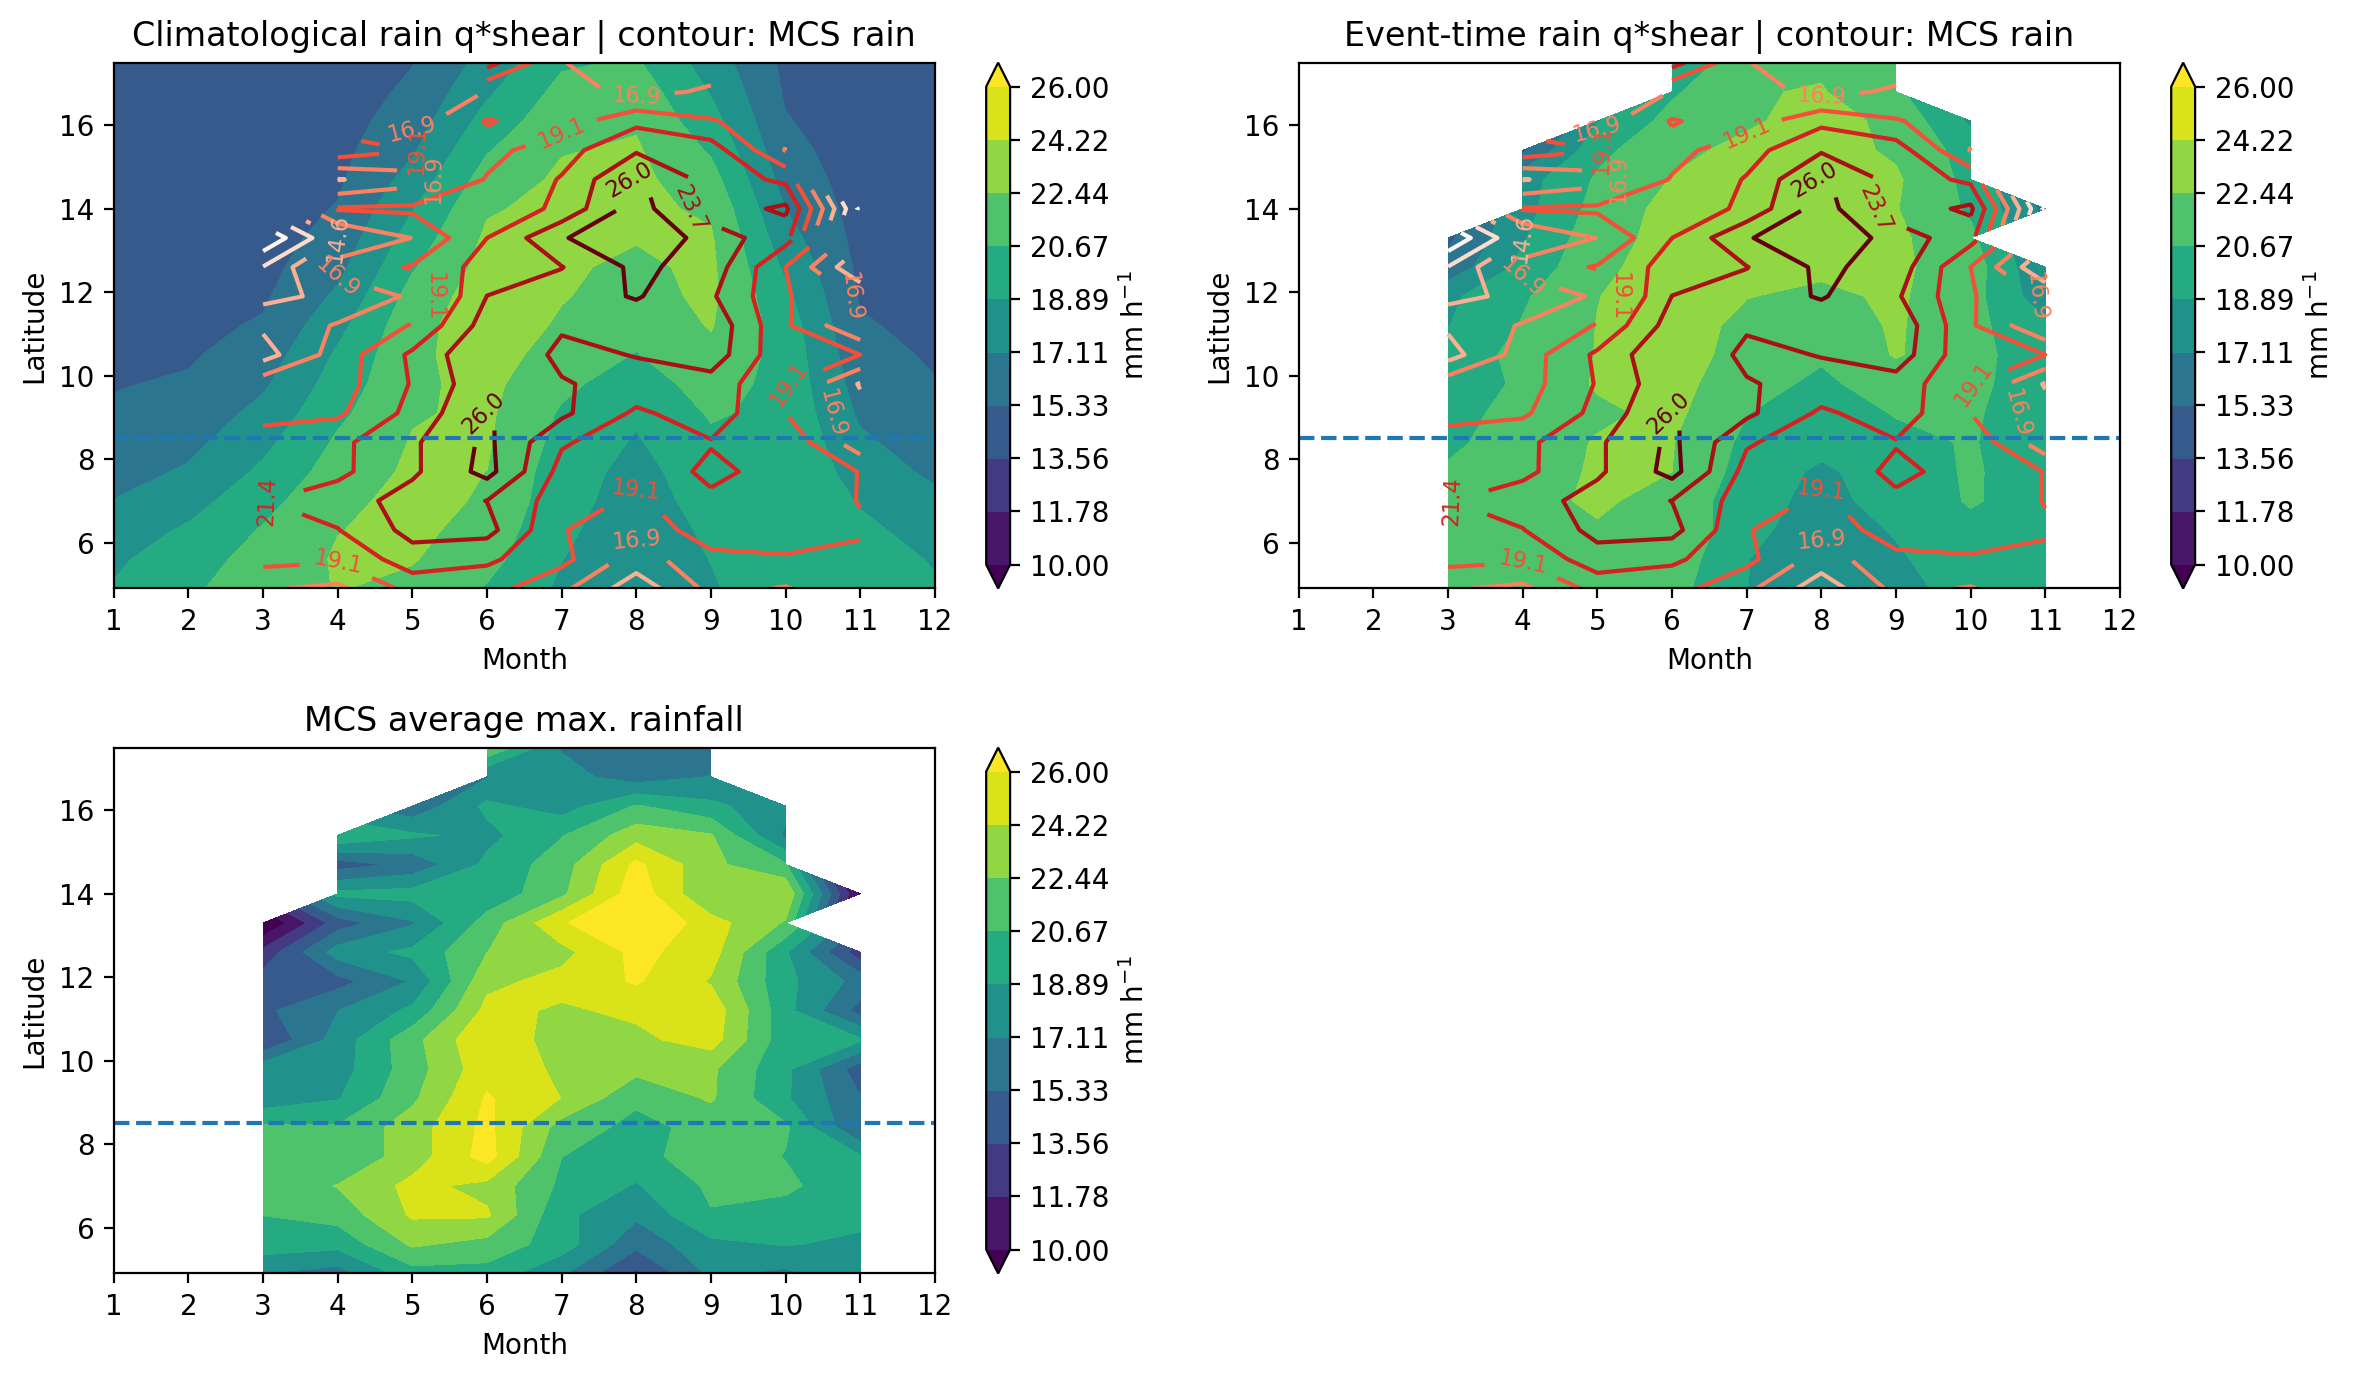

In [217]:
contour = {'x' : np.arange(1,13).astype(str), 'y':qdiff.latitude.values, 'data' : pmax.T, 'levels':np.linspace(10,26,8), 'cmap':'Reds'}

f = plt.figure(figsize=(12,7), dpi=200)
ax = f.add_subplot(221)
#contour2 = {'x' : tdiff.month.values, 'y': cape.latitude.values, 'data': q.T, 'levels': [10,12,14,14.5,15,15.2,15.5,15.7,16], 'color':'red'}
draw_map(ax, 15+qshearmean.T*qshear_slope, np.arange(1,13).astype(str), qdiff.latitude.values , 10, 26, 10, cmap='viridis',  \
         title=r"Climatological rain q*shear | contour: MCS rain", text='(e)', cbar_label='mm h$^{-1}$', contour=contour)


ax = f.add_subplot(222)
draw_map(ax,15+qshearevent.T*qshear_slope, np.arange(1,13).astype(str), ds.lat.values , 10, 26,10, \
         title=r"Event-time rain q*shear | contour: MCS rain",  text='(c)',cmap='viridis', cbar_label='mm h$^{-1}$', contour=contour)

ax = f.add_subplot(223)
draw_map(ax,pmax.T, np.arange(1,13).astype(str), qdiff.latitude.values , 10, 26,10, \
         title=r"MCS average max. rainfall",  text='(c)',cmap='viridis', cbar_label='mm h$^{-1}$')

# ax = f.add_subplot(224)
# draw_map(ax,qshearevent.T, np.arange(1,13).astype(str), qdiff.latitude.values , 0, 300,20, \
#          title=r"Original ",  text='(c)',cmap='jet', cbar_label='mm h$^{-1}$')



plt.tight_layout()
plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/mean_qshear_rain.jpg')

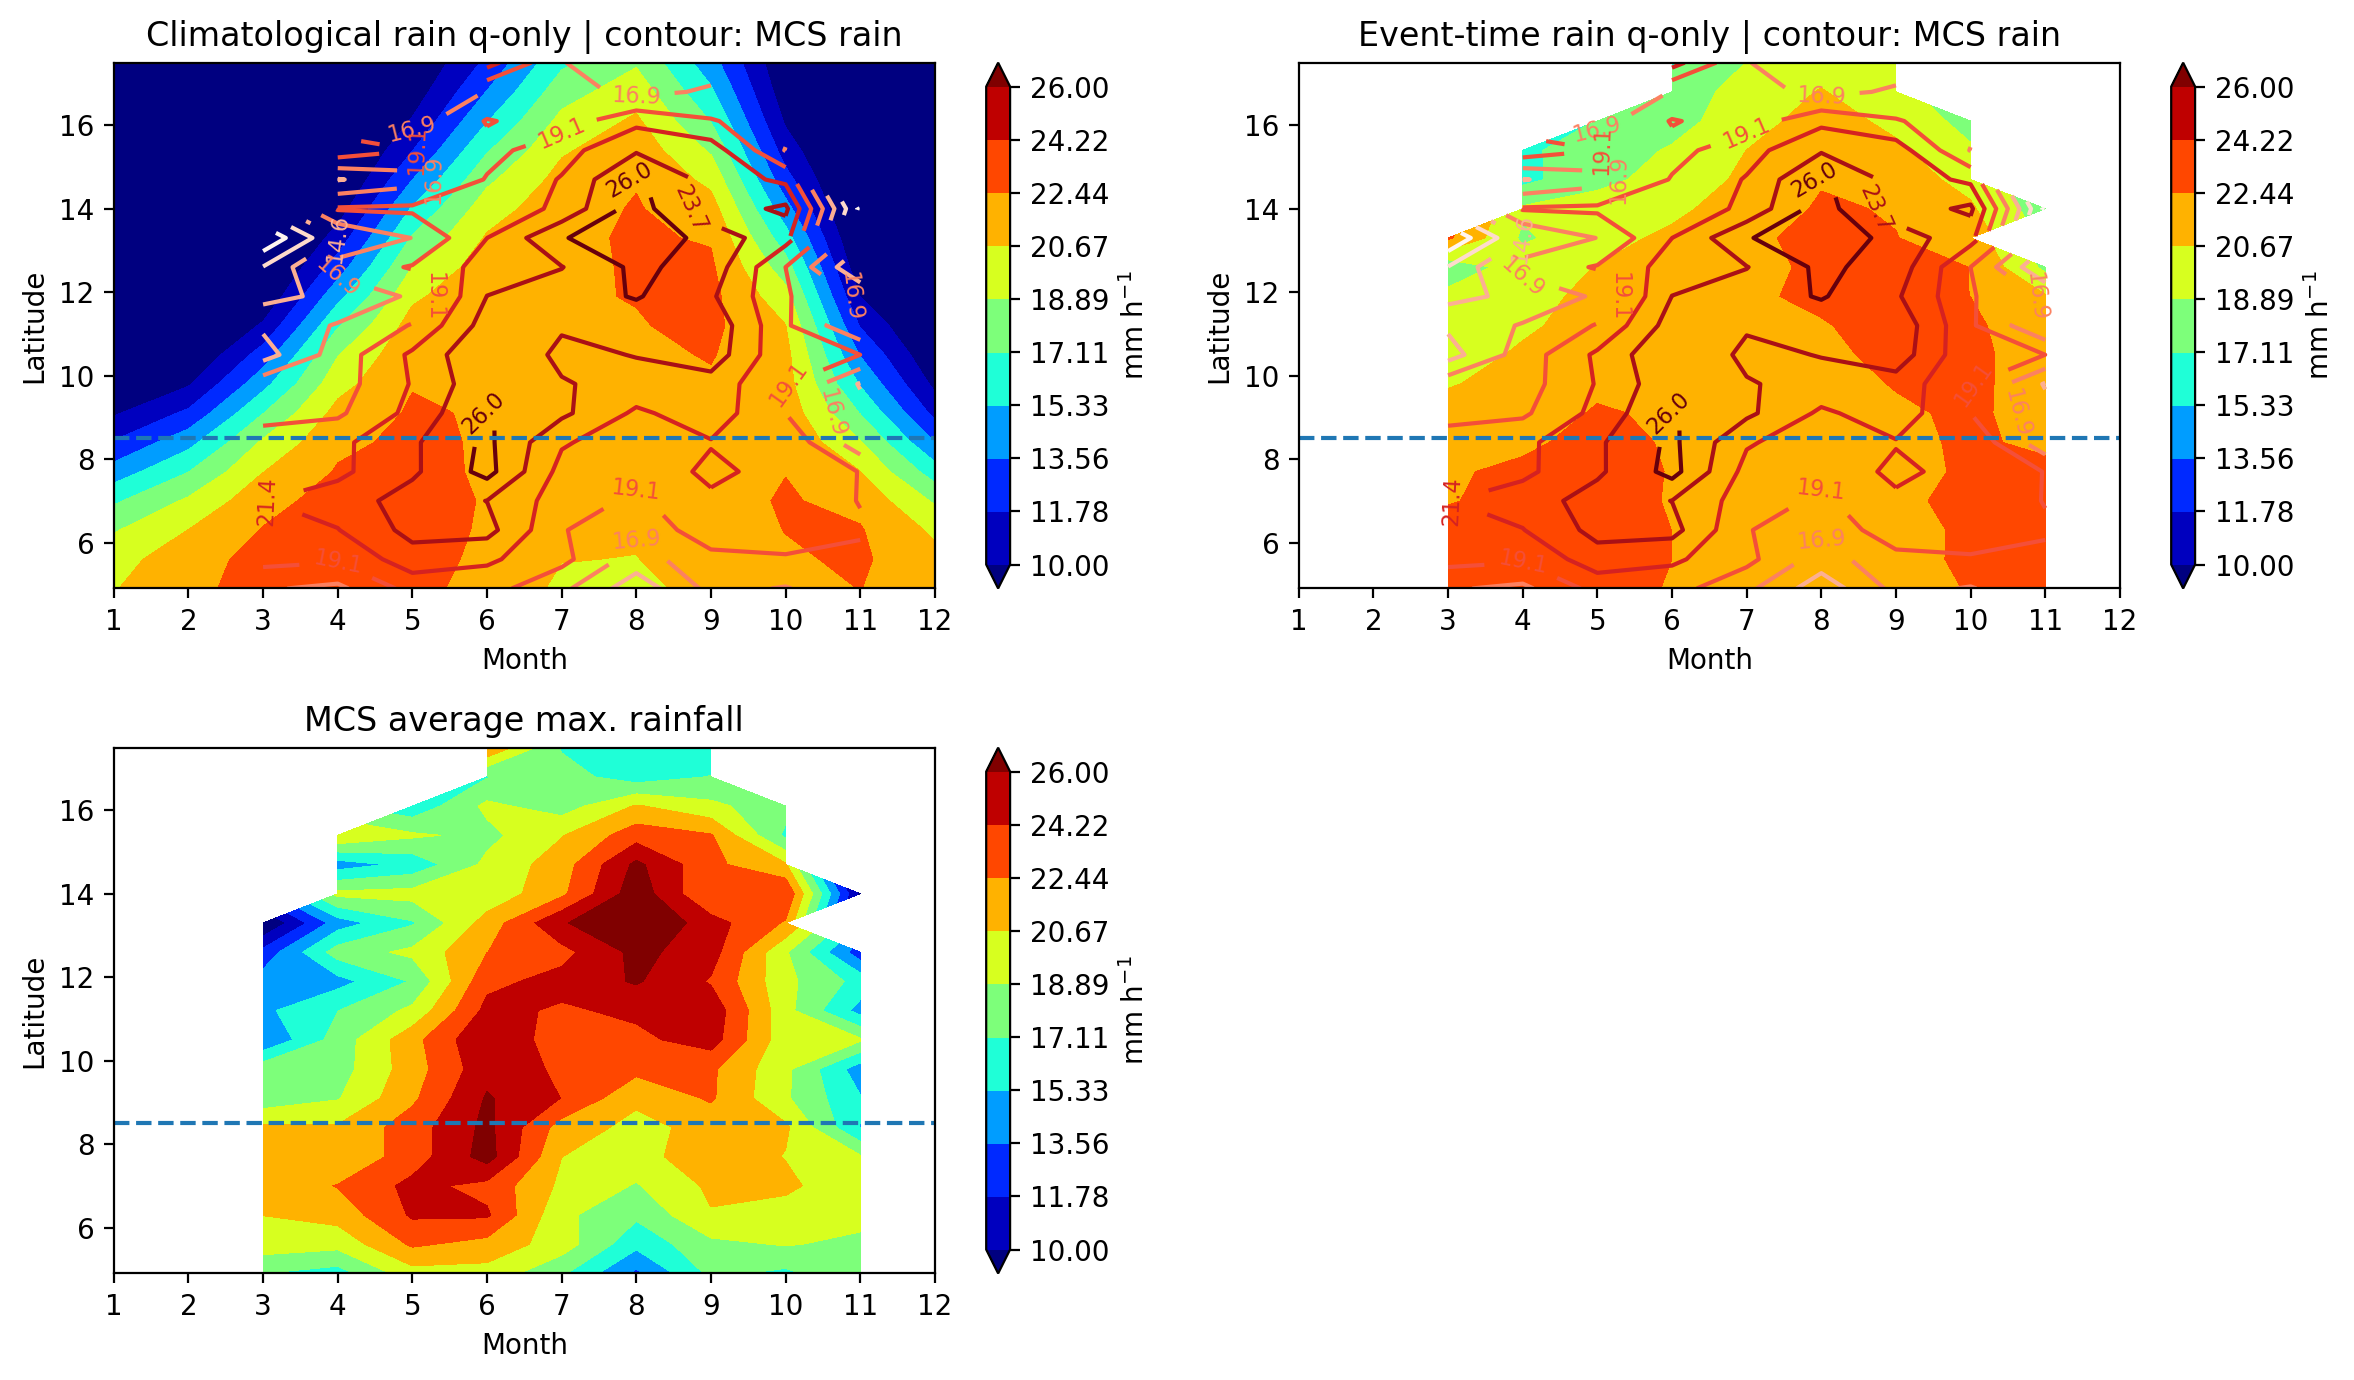

In [216]:
contour = {'x' : np.arange(1,13).astype(str), 'y':qdiff.latitude.values, 'data' : pmax.T, 'levels':np.linspace(10,26,8), 'cmap':'Reds'}

f = plt.figure(figsize=(12,7), dpi=200)
ax = f.add_subplot(221)
#contour2 = {'x' : tdiff.month.values, 'y': cape.latitude.values, 'data': q.T, 'levels': [10,12,14,14.5,15,15.2,15.5,15.7,16], 'color':'red'}
draw_map(ax, 1+qmean.T*qslope, np.arange(1,13).astype(str), qdiff.latitude.values , 10, 26, 10, cmap='jet',  \
         title=r"Climatological rain q-only | contour: MCS rain", text='(e)', cbar_label='mm h$^{-1}$', contour=contour)


ax = f.add_subplot(222)
draw_map(ax,1+mean['q'].T*qslope, np.arange(1,13).astype(str), ds.lat.values , 10, 26,10, \
         title=r"Event-time rain q-only | contour: MCS rain",  text='(c)',cmap='jet', cbar_label='mm h$^{-1}$', contour=contour)

ax = f.add_subplot(223)
draw_map(ax,pmax.T, np.arange(1,13).astype(str), qdiff.latitude.values , 10, 26,10, \
         title=r"MCS average max. rainfall",  text='(c)',cmap='jet', cbar_label='mm h$^{-1}$')

# ax = f.add_subplot(224)
# draw_map(ax,qshearevent.T, np.arange(1,13).astype(str), qdiff.latitude.values , 0, 300,20, \
#          title=r"Original ",  text='(c)',cmap='jet', cbar_label='mm h$^{-1}$')



plt.tight_layout()
plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/mean_qOnly_rain.jpg')

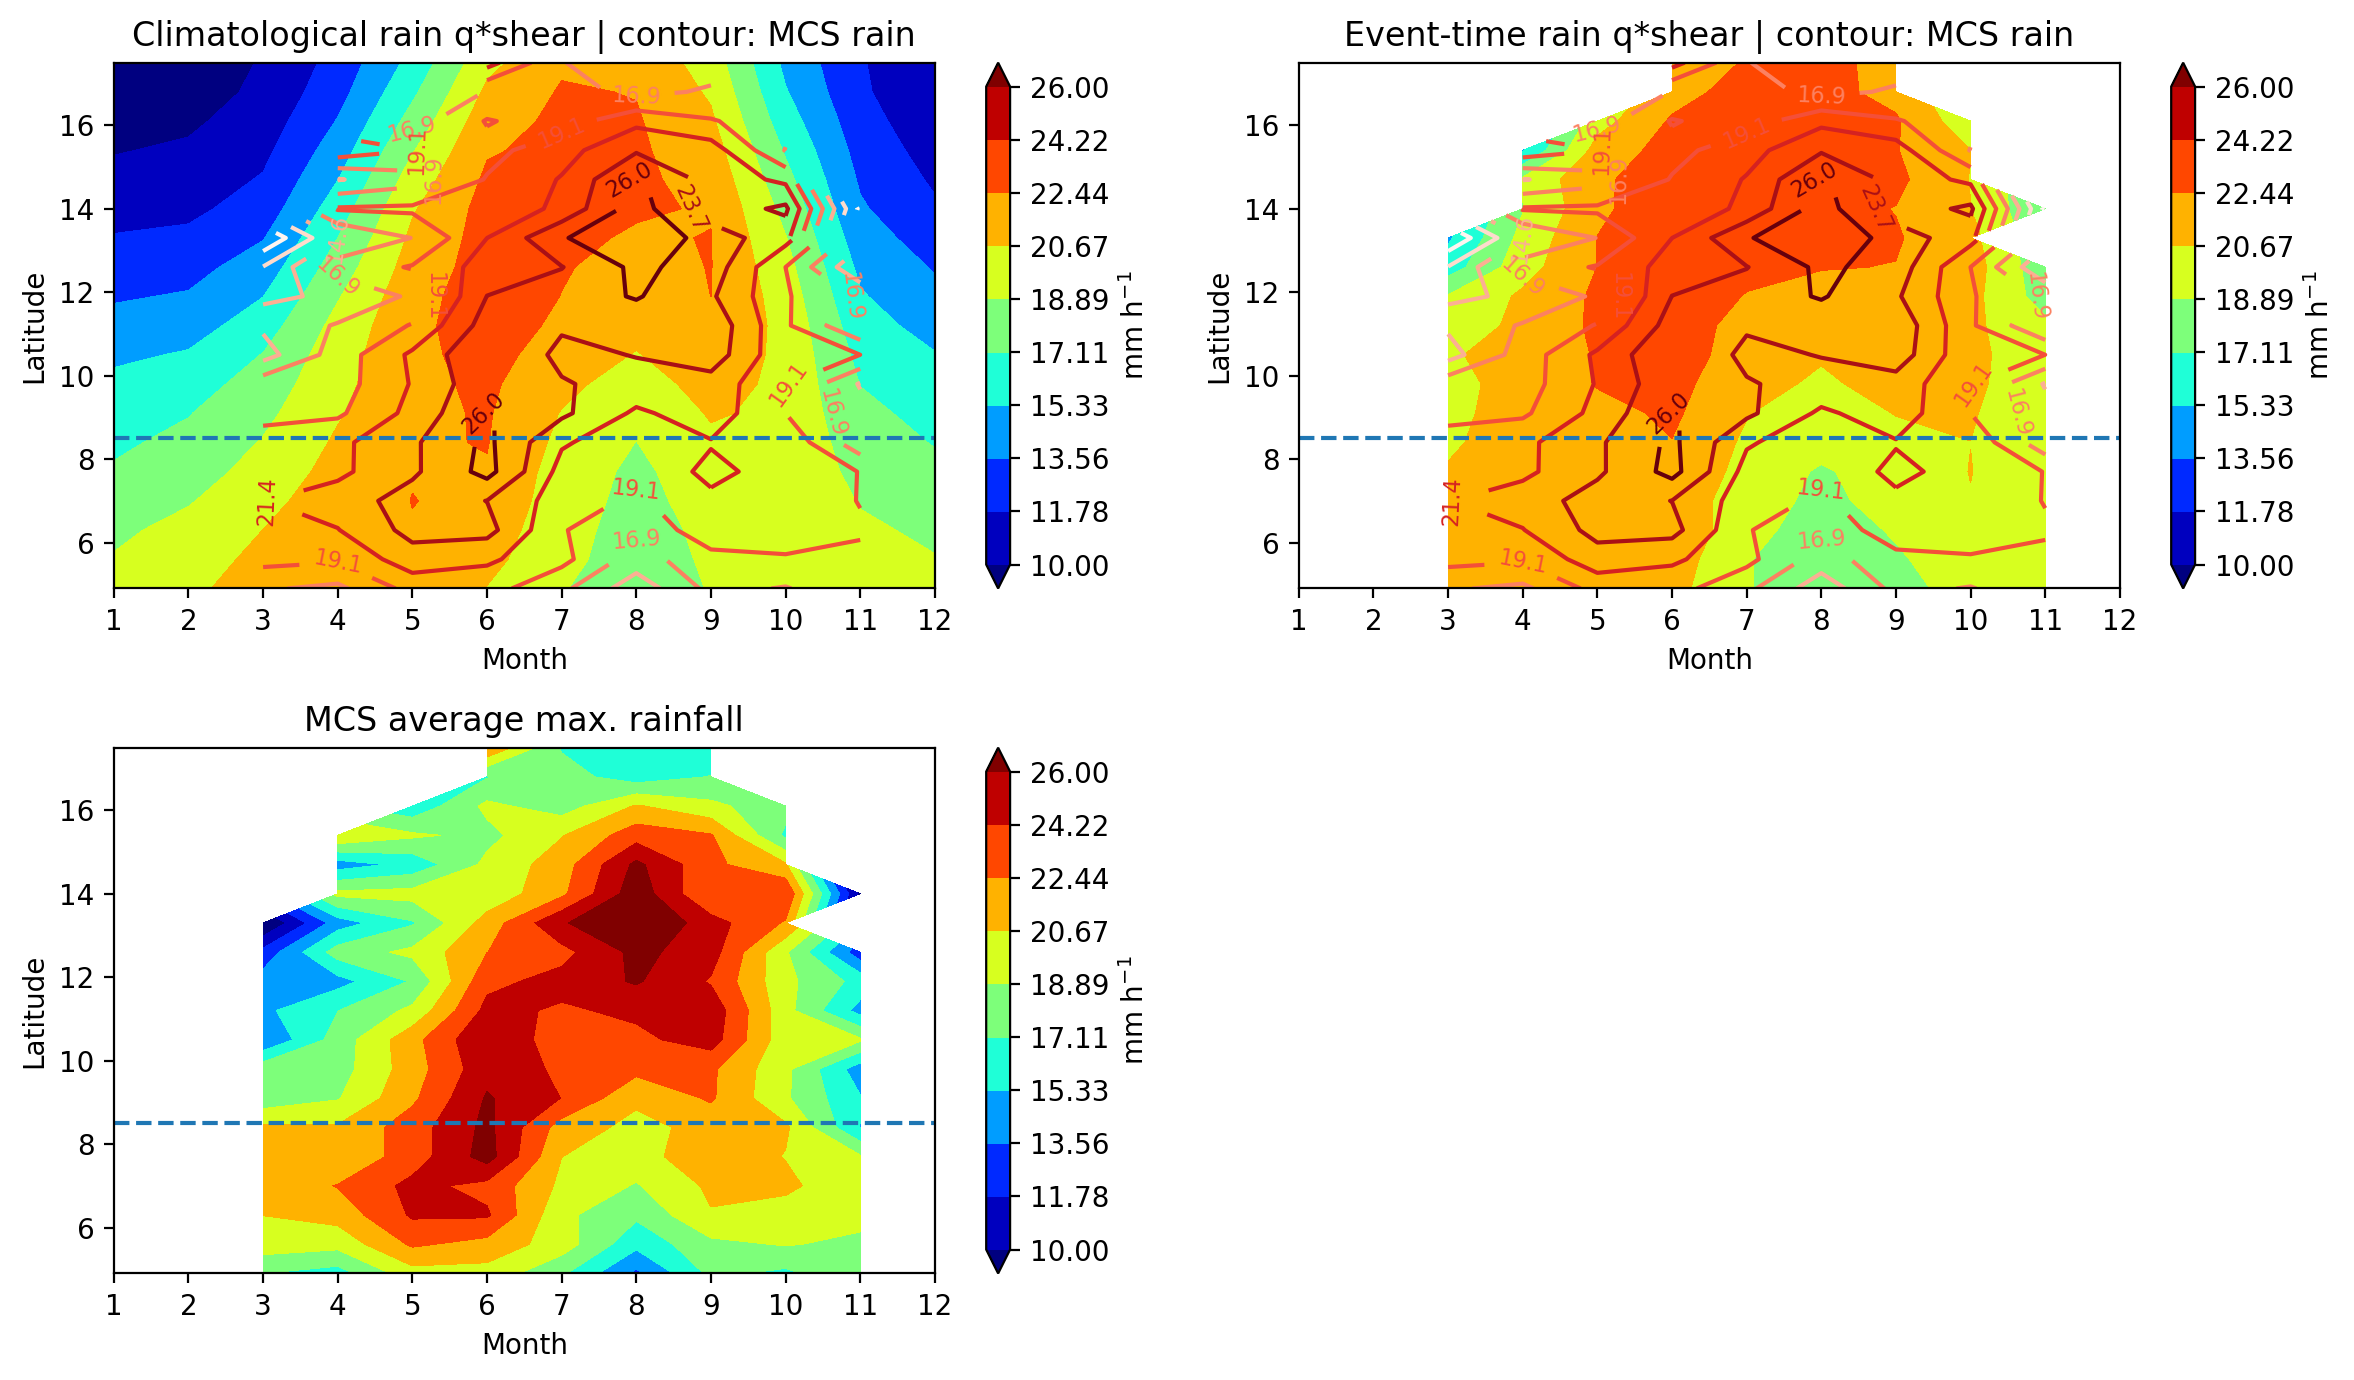

In [215]:
contour = {'x' : np.arange(1,13).astype(str), 'y':qdiff.latitude.values, 'data' : pmax.T, 'levels':np.linspace(10,26,8), 'cmap':'Reds'}

f = plt.figure(figsize=(12,7), dpi=200)
ax = f.add_subplot(221)
#contour2 = {'x' : tdiff.month.values, 'y': cape.latitude.values, 'data': q.T, 'levels': [10,12,14,14.5,15,15.2,15.5,15.7,16], 'color':'red'}
draw_map(ax, 15.1+shearmean.T*shear_slope, np.arange(1,13).astype(str), qdiff.latitude.values , 10, 26, 10, cmap='jet',  \
         title=r"Climatological rain q*shear | contour: MCS rain", text='(e)', cbar_label='mm h$^{-1}$', contour=contour)


ax = f.add_subplot(222)
draw_map(ax,15.1+mean['shear'].T*shear_slope, np.arange(1,13).astype(str), ds.lat.values , 10, 26,10, \
         title=r"Event-time rain q*shear | contour: MCS rain",  text='(c)',cmap='jet', cbar_label='mm h$^{-1}$', contour=contour)

ax = f.add_subplot(223)
draw_map(ax,pmax.T, np.arange(1,13).astype(str), qdiff.latitude.values , 10, 26,10, \
         title=r"MCS average max. rainfall",  text='(c)',cmap='jet', cbar_label='mm h$^{-1}$')

# ax = f.add_subplot(224)
# draw_map(ax,qshearevent.T, np.arange(1,13).astype(str), qdiff.latitude.values , 0, 300,20, \
#          title=r"Original ",  text='(c)',cmap='jet', cbar_label='mm h$^{-1}$')



plt.tight_layout()
plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/mean_shearOnly_rain.jpg')

In [174]:
def groupedAvg(myArray, N=7):
    result = np.cumsum(myArray, 0)[N - 1::N, :] / float(N)
    result[1:,:] = result[1:, :] - result[:-1, :]
    return result

In [175]:
out = groupedAvg(extr_rain.values.T, N=7)

In [176]:
out.shape

(20, 12)

In [177]:
qdiff.latitude.values[0:-1]-qdiff.latitude.values[1::]

array([-0.6999998 , -0.7000003 , -0.6999998 , -0.6999998 , -0.6999998 ,
       -0.70000076, -0.6999998 , -0.6999998 , -0.6999998 , -0.6999998 ,
       -0.70000076, -0.6999998 , -0.6999998 , -0.6999998 , -0.6999998 ,
       -0.70000076, -0.69999886, -0.70000076], dtype=float32)